In [1]:
'''
Trains a simple deep RNN on the MNIST dataset.
'''
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt


batch_size = 32
num_classes = 10
epochs = 2

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 1, 784)
x_test = x_test.reshape(10000, 1, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = y_train.reshape(60000,10)
y_test = y_test.reshape(10000,10)

model = Sequential()
model.add(keras.layers.recurrent.SimpleRNN(100, input_dim=784, input_length=1, return_sequences=True))
# model.add(keras.layers.recurrent.SimpleRNN(32, return_sequences=True))
# model.add(keras.layers.recurrent.SimpleRNN(16, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform',
#                                  recurrent_initializer='orthogonal', bias_initializer='zeros',
#                                  kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
#                                  activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
#                                  bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(keras.layers.recurrent.SimpleRNN(10))

model.summary()

Using TensorFlow backend.


60000 train samples
10000 test samples


/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(100, return_sequences=True, input_shape=(1, 784))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 100)            88500     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                1110      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [2]:
for layer in model.layers:
    print(layer.get_weights()[0].shape)

(784, 100)
(100, 10)


In [10]:
for layer in model.layers:
    print(layer.recurrent_kernel)

<tf.Variable 'simple_rnn_1/recurrent_kernel:0' shape=(100, 100) dtype=float32_ref>
<tf.Variable 'simple_rnn_2/recurrent_kernel:0' shape=(10, 10) dtype=float32_ref>


AttributeError: 'Variable' object has no attribute 'get_weights'

In [35]:
#getting the recurrent weights like this is BS
import tensorflow as tf
x = model.weights[1]

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)
v = sess.run(x)    
print(v) # will show you your variable.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'init_1' type=NoOp>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main\n    "__main__", fname, loader, pkg_name)', 'File "/usr/lib/python2.7/runpy.py", line 72, in _run_code\n    exec code in run_globals', 'File "/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/asagodi/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/asagodi/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/asagodi/.local/lib/python2.7/site

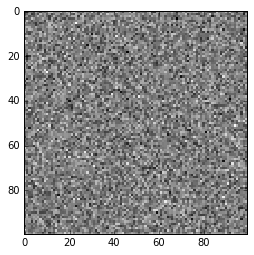

In [38]:
plt.imshow(v, interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [36]:
# [method for method in dir(model.layers) if callable(getattr(model.layers, method))]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Visualize weights

W = model.layers[0].get_weights()
W = np.squeeze(W[0])
print("W shape : ", W.shape)
W = np.squeeze(W[0])

plt.imshow(W.reshape(20,20), interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [ ]:
#find pattern
W = model.layers[0].get_weights()
weights = np.squeeze(W[0])

inp = np.zeros((28,28))
inp[1:5:2,::3] = 1
inp = inp.reshape((784,))

outp = inp.dot(weights) > .5

plt.imshow(outp.reshape(20,20), interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [ ]:
inp = np.ones((784,))
outp = inp.dot(weights)
average_act = np.sum(outp)/512

In [ ]:
W = model.layers[0].get_weights()[0]
W.shape

In [8]:
import numpy as np
import matplotlib.pyplot as plt